In [5]:
import joblib
from sklearn.utils import resample


def load_training_data(path='./data/training_data/gaziaer_all/all_training_data_processed.joblib'):
    '''
    Loads the training data from the given path
    args:
        path: path to the training data
    returns:
        gdf: geodataframe of the training data
    '''
    gdf = joblib.load(path)
    return gdf

def load_inference_data(path= './data/training_data/gaziaer_all/all_inference_data.joblib'):
    '''
    Loads the inference data from the given path
    args:
        path: path to the inference data
    returns:
        gdf: geodataframe of the inference data
    '''
    gdf = joblib.load(path)
    return gdf

def load_classifier(path='./data/joblibs/classifiers/random_forest_classifier.joblib'):
    '''
    Loads the classifier from the given path
    args:
        path: path to the classifier
    returns:
        clf: classifier
    '''
    clf = joblib.load(path)
    return clf

def remove_october_coloumns_from_df(df):
    '''
    Removes the october coloumns from the dataframe becasue they can't be used for inference
    args:
        df: dataframe
    returns:
        df: dataframe without october coloumns
    '''
    cols = df.columns
    october_cols = [col for col in cols if col.endswith('-10')]
    df = df.drop(october_cols, axis=1)
    return df

def convert_int_labels_to_string_labels(df):
    '''
    Converts the integer labels to string labels
    args:
        df: dataframe
    returns:
        df: dataframe with string labels
    '''
    labels_dict = {
        -1: 'Unknown',
         0: 'Uncultivated',
         1: 'Cultivated',
         2: 'Urban_Water'
    }
    labels_col = 'Labels'
    df[labels_col] = df[labels_col].map(labels_dict)
    return df

def convert_labels_to_binary(df):
    '''
    Converts the labels to binary labels after removing the unknown class
    args:
        df: dataframe
    returns:
        df: dataframe with binary labels
    '''
    
    labels_dict = {
        'Uncultivated': 'Uncultivated',
        'Cultivated': 'Cultivated',
        'Urban_Water': 'Uncultivated'
    }
    labels_col = 'Labels'
    df[labels_col] = df[labels_col].map(labels_dict)
    return df

def remove_unknown_class(df):
    '''
    Removes the unknown class from the dataframe
    args:
        df: dataframe
    returns:
        df: dataframe without the unknown class
    '''
    df = df[df['Labels'] != 'Unknown']
    return df

def reoder_columns_df_by_name(df):
    '''
    Reorders the columns of the dataframe by name so that they can be used in the classifier without errors
    args:
        df: dataframe
    returns:
        df: dataframe with reordered columns
    '''
    cols = df.columns
    cols = sorted(cols)
    df = df[cols]
    return df

def normalize_df(df):
    '''
    Normalizes the dataframe neumerical features by subtracting the mean and dividing by the standard deviation
    args:
        df: dataframe
    returns:
        df: normalized dataframe
    '''
    df = df.copy()
    df_cols = df.columns
    nuemerical_cols = [col for col in df_cols if '-' in col]
    for col in nuemerical_cols:
        df[col] = (df[col] - df[col].mean()) / df[col].std()
    return df


def downsample_majority_classes(df):
    '''
    Downsamples the majority classes to the size of the minority class based on the Labels coloumn
    args:
        df: dataframe
    returns:
        df: downsampled dataframe
    '''
    df = df.copy()
    labels_value_counts = df['Labels'].value_counts()
    min_count = labels_value_counts.min()
    df = df.groupby('Labels').apply(lambda x: resample(x, n_samples=min_count, random_state=42))
    df = df.reset_index(drop=True)
    return df

In [6]:
%%time
# Load the training data
training_data_gdf_all = load_training_data()
#Load the inference data
inference_data_gdf_all = load_inference_data()

print('Training data Shape: ', training_data_gdf_all.shape)
print('Inference data Shape: ', inference_data_gdf_all.shape)

Training data Shape:  (6131795, 76)
Inference data Shape:  (3906030, 62)
CPU times: total: 18.1 s
Wall time: 20.3 s


In [12]:
#Sample the training data and inference data for faster experimentation (remove this for final model)
num_samples = int(1e6) # 1 million samples
training_data_gdf = training_data_gdf_all.sample(num_samples) # out of 6.1 million samples
inference_data_gdf = inference_data_gdf_all.sample(num_samples)# out of 3.9 million samples

#Remove the october coloumns from training data and inference data
training_data_gdf = remove_october_coloumns_from_df(training_data_gdf)
inference_data_gdf = remove_october_coloumns_from_df(inference_data_gdf)

#Convert the integer labels to string labels
training_data_gdf = convert_int_labels_to_string_labels(training_data_gdf)
inference_data_gdf = convert_int_labels_to_string_labels(inference_data_gdf)

#Reorder the columns of the training data and inference data by name
training_data_gdf = reoder_columns_df_by_name(training_data_gdf)
inference_data_gdf = reoder_columns_df_by_name(inference_data_gdf)

#Normalize the training data and inference data
# training_data_gdf = normalize_df(training_data_gdf)
# inference_data_gdf = normalize_df(inference_data_gdf)

#Remove the unknown labels from the training data and convert the labels to binary for training data
training_data_gdf = remove_unknown_class(training_data_gdf)
training_data_gdf = convert_labels_to_binary(training_data_gdf)

In [13]:
import folium
#Visualize the training and inference data on a map (only run for less than 5000 rows to avoid crashing)
if len(training_data_gdf) <= 5000 and len(inference_data_gdf) <= 5000:
        #Create a map and add the training data colored by the target state
        m = training_data_gdf.explore(column='target_state', name='Training Data', m=None)
        #Add the inference data colored by the target state
        m = inference_data_gdf.explore(column='target_state', name='Inference Data', m=m, legend=False)

        #Add Esri Satellite layer as a base layer
        folium.TileLayer(
                tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
                attr = 'Esri',
                name = 'Esri Satellite',
                overlay = False,
                control = True
        ).add_to(m)
        #Add the layer control
        folium.LayerControl().add_to(m)
        #Display the map
        # m


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#limit training data to the years 2019, 2020, 2021
training_data_gdf = training_data_gdf[training_data_gdf['year'].isin([2019, 2020, 2021])]

#Balance the training data
training_data_gdf = downsample_majority_classes(training_data_gdf)

#Meta columns are the columns that are not used for training
meta_cols = ['Lat', 'Lon', 'geometry', 'target_state', 'year', 'Labels']

#Get the training data without the meta columns
X = training_data_gdf.drop(meta_cols, axis=1)

#Get the target labels
y = training_data_gdf['Labels']

#Split the data into training and validation data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.5, random_state=42)

#Initialize the classifier
clf = RandomForestClassifier(n_estimators=30, random_state=42, n_jobs=-1, verbose=2)

#Train the classifier
clf.fit(X_train, y_train)

#Print the evaluation metrics
print('Accuracy: ', accuracy_score(y_val, clf.predict(X_val)))
print('Confusion Matrix: \n', confusion_matrix(y_val, clf.predict(X_val)))
print('Classification Report: \n', classification_report(y_val, clf.predict(X_val)))

#Save the classifier
save_path = './data/joblibs/classifiers/random_forest_classifier.joblib'
joblib.dump(clf, save_path)
print('Classifier saved to: ', save_path)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 30
building tree 2 of 30
building tree 3 of 30
building tree 4 of 30
building tree 5 of 30
building tree 6 of 30
building tree 7 of 30
building tree 8 of 30
building tree 9 of 30
building tree 10 of 30
building tree 11 of 30
building tree 12 of 30
building tree 13 of 30
building tree 14 of 30
building tree 15 of 30
building tree 16 of 30
building tree 17 of 30
building tree 18 of 30
building tree 19 of 30
building tree 20 of 30
building tree 21 of 30
building tree 22 of 30
building tree 23 of 30
building tree 24 of 30
building tree 25 of 30
building tree 26 of 30
building tree 27 of 30
building tree 28 of 30
building tree 29 of 30
building tree 30 of 30


[Parallel(n_jobs=-1)]: Done  23 out of  30 | elapsed:    4.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    6.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  23 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.1s finished


Accuracy:  0.9780668355427086


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  23 out of  30 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.1s finished


Confusion Matrix: 
 [[96194   237]
 [ 3997 92613]]


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  23 out of  30 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.1s finished


Classification Report: 
               precision    recall  f1-score   support

  Cultivated       0.96      1.00      0.98     96431
Uncultivated       1.00      0.96      0.98     96610

    accuracy                           0.98    193041
   macro avg       0.98      0.98      0.98    193041
weighted avg       0.98      0.98      0.98    193041

Classifier saved to:  ./data/joblibs/classifiers/random_forest_classifier.joblib


# Inference Part
 (I will handle this part)

In [15]:
#Load the classifier
clf = load_classifier()

#Drop the meta columns from the inference data
X = inference_data_gdf.drop(meta_cols, axis=1)

#Predict the labels
y_pred = clf.predict(X)

#Add the predicted labels to the inference data
inference_data_gdf['Predicted_Labels'] = y_pred

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  23 out of  30 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=12)]: Done  30 out of  30 | elapsed:    0.8s finished


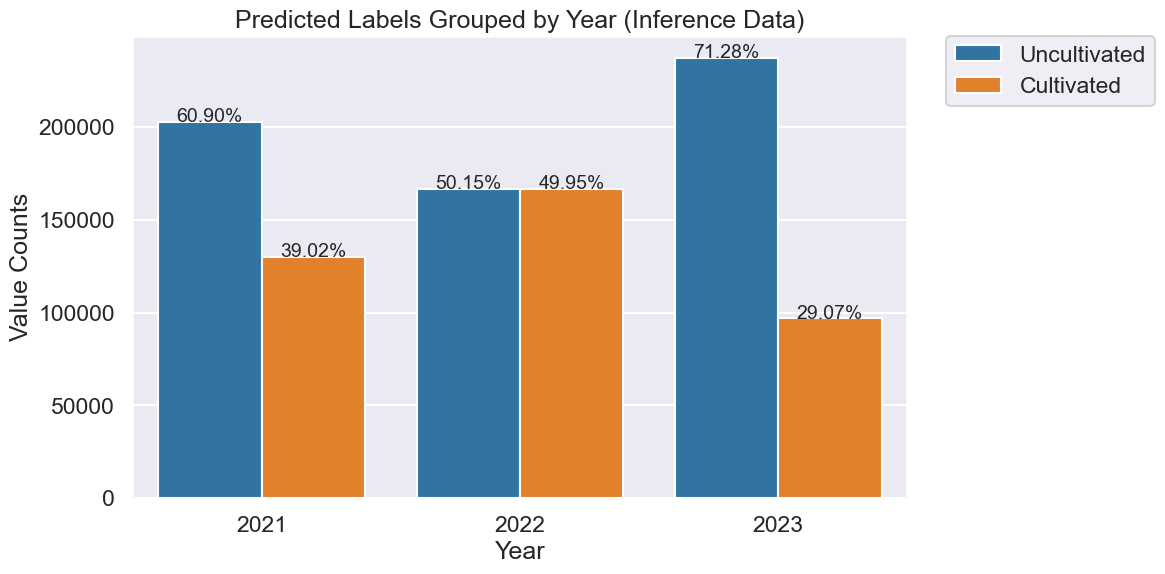

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')



#Plot the predicted labels value counts grouped by year
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='year', hue='Predicted_Labels', data=inference_data_gdf, ax=ax)
#Write the precnetage of each label on top of the bars
count = 0
for p in ax.patches:
    count += 1
    if count < 4:
        len_of_labels = len(inference_data_gdf[inference_data_gdf['year'] == 2021])
    elif count <7:
        len_of_labels = len(inference_data_gdf[inference_data_gdf['year'] == 2022])
    else:
        len_of_labels = len(inference_data_gdf[inference_data_gdf['year'] == 2023])
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len_of_labels*100),
            ha="center",
            fontsize=14)
#Position the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#Set the title, x label and y label
ax.set_title('Predicted Labels Grouped by Year (Inference Data)')
ax.set_xlabel('Year')
ax.set_ylabel('Value Counts')
plt.show()

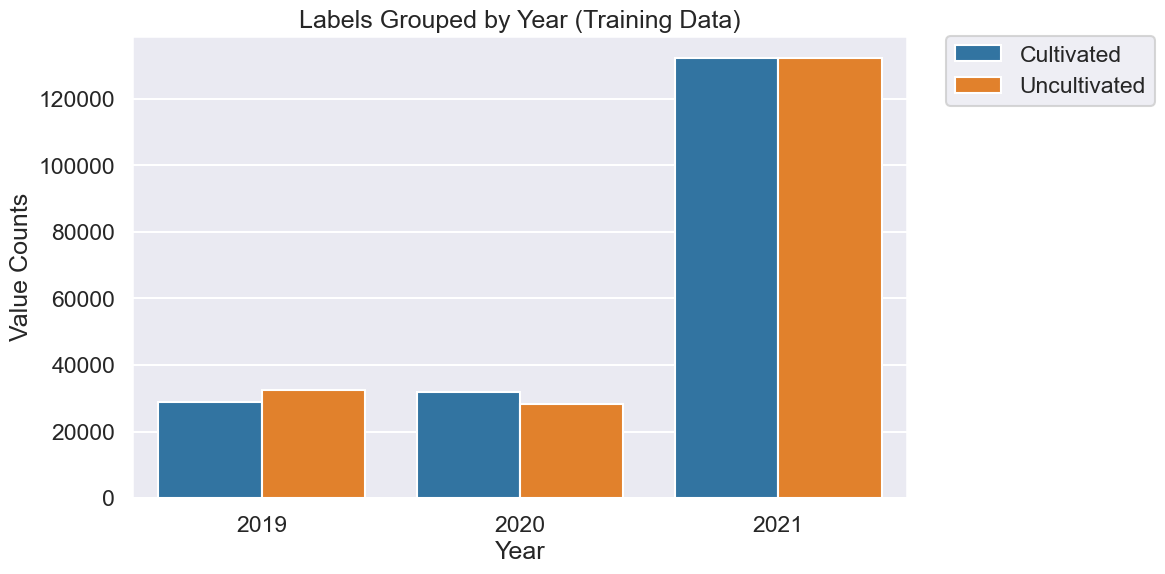

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')



#Plot the predicted labels value counts grouped by year
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(x='year', hue='Labels', data=training_data_gdf, ax=ax)
#Position the legend outside the plot
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#Set the title, x label and y label
ax.set_title('Labels Grouped by Year (Training Data)')
ax.set_xlabel('Year')
ax.set_ylabel('Value Counts')
plt.show()